In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from scipy.fftpack import fft
import shutil
from pydub import AudioSegment

from functools import partial
#import ftransc

c:\Users\acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        # speaker_id,version,gender,age,reason = speaker.split("-")
        #sp = speaker.split("-")
        #speaker_id = sp[0]
        #gender = sp[2]
        #age =sp[3]


        # Load audio
        waveform, sample_rate = load_audio(file_path)
        audio_segment = AudioSegment.from_file(file_path)
        dataset.append([waveform, sample_rate,audio_segment])
        #dataset.append([waveform, sample_rate, label, speaker_id, gender,age])

    return dataset



In [4]:
burping_data = load_audio_files('./sound_data/dustan_baby/burpme_Eh/', 'burpme')
tired_data = load_audio_files('./sound_data/dustan_baby/tired_owh/', 'tired')
hungry_data = load_audio_files('./sound_data/dustan_baby/hungry_Nah/', 'hungry')
poop_data = load_audio_files('./sound_data/dustan_baby/poop_eairh/', 'poop')
discomfort_data = load_audio_files('./sound_data/dustan_baby/uncomfortable_heh/', 'discomfort')

In [12]:
hungry_waveform = hungry_data[0][0]
hungry_sample_rate = hungry_data[0][1]

In [13]:
def fast_furior_transform(waveform,sample):
    yf = np.abs(librosa.stft(waveform))
    img = librosa.display.specshow(librosa.amplitude_to_db(yf),y_axis='log')
    plt.colorbar()
    

In [14]:
def Spectrogram(waveform,sample):
    waveform = librosa.stft(waveform)
    waveformdb = librosa.power_to_db(abs(waveform))
    plt.figure(figsize=(15, 3))
    librosa.display.specshow(waveformdb, sr=sample, x_axis='time', y_axis='log',cmap = 'magma')
    plt.colorbar()
    
    return waveformdb

In [15]:
def mel_spectrogram(waveform,sample,n_fft=2048,hop_length=128):
    #fast_fourier_transf = np.fft.fft(waveform)
   
    audio_stft = librosa.feature.melspectrogram(y=waveform,n_fft=n_fft,hop_length=hop_length)
    log_spectro = librosa.power_to_db(audio_stft)
    librosa.display.specshow(log_spectro, sr=sample, x_axis='time', y_axis='fft',cmap = 'magma')
    
    
    return log_spectro

In [16]:
def rms(waveform,sample):
    # Get RMS value from each frame's magnitude value
    S, phase = librosa.magphase(librosa.stft(waveform))
    rms = librosa.feature.rms(S=S)
    # Plot the RMS energy
    fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
    times = librosa.times_like(rms)
    ax[0].semilogy(times, rms[0], label='RMS Energy')
    ax[0].set(xticks=[])
    ax[0].legend()
    ax[0].label_outer()
    data =librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(data,y_axis='log', x_axis='time', ax=ax[1],cmap = 'magma')
    ax[1].set(title='log Power spectrogram')
    return data

In [17]:
def zero_crossing(waveform,sample):
    zcrs = librosa.feature.zero_crossing_rate(waveform)
    data = librosa.power_to_db(zcrs)
    print(f"Zero crossing rate: {sum(librosa.zero_crossings(waveform))}")
    plt.figure(figsize=(15, 3))
    plt.plot(zcrs[0])
    plt.title('Action Rock')
    return data


In [18]:
def mel_freq(waveform,sample):
    mfccs = librosa.feature.mfcc(waveform, sr=sample,dct_type = 2)
    data = librosa.power_to_db(mfccs)
    # Displaying  the MFCCs:
    librosa.display.specshow(mfccs, sr=sample, x_axis='hz',cmap = 'magma')
    return data,mfccs

In [19]:
hungry_waveform.shape


(22932,)

In [20]:
hungry_sample_rate

22050

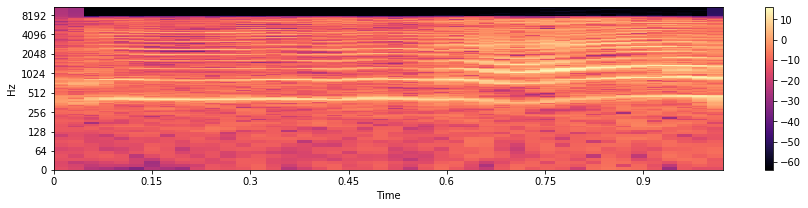

In [21]:
spec = Spectrogram(hungry_waveform,hungry_sample_rate)

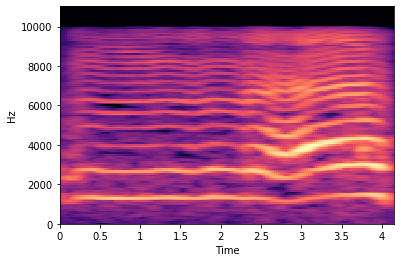

In [22]:
mel_spec = mel_spectrogram(hungry_waveform,hungry_sample_rate)

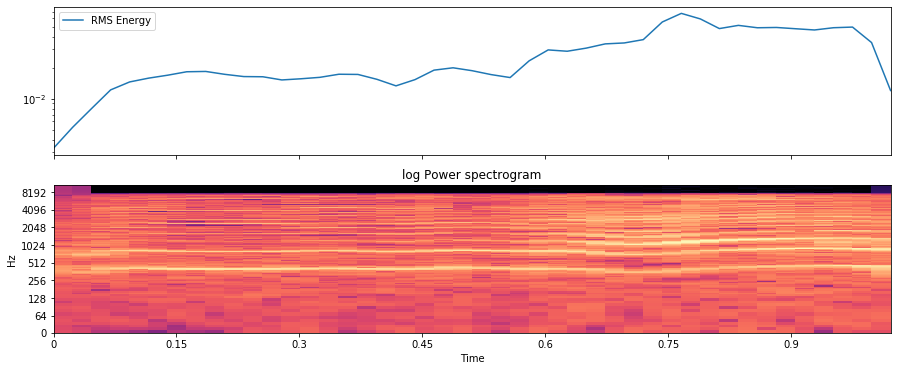

In [23]:
Rms = rms(hungry_waveform,hungry_sample_rate)

Zero crossing rate: 2621


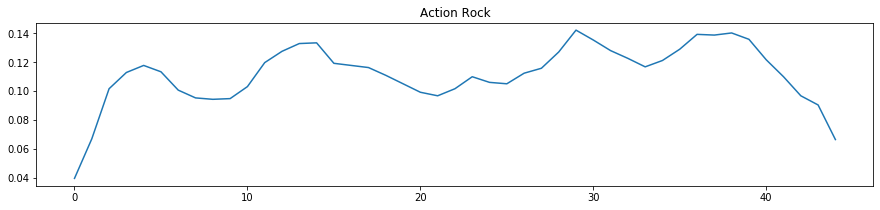

In [24]:
zero = zero_crossing(hungry_waveform,hungry_sample_rate)

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00752398 -0.00712848 -0.00551579 ...  0.00132812 -0.0019003
 -0.00157612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


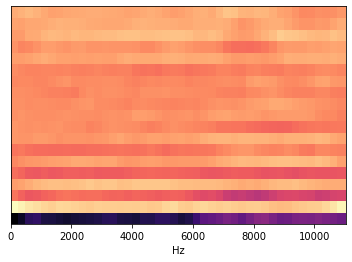

In [25]:
melfreq,mfcc = mel_freq(hungry_waveform,hungry_sample_rate)

In [26]:
print(mfcc.shape)
print(melfreq.shape)
print(mfcc[0][1])

(20, 45)
(20, 45)
-360.07083


In [34]:
def create_images(dataset,modeltype,typeimg, label_dir,num):
    # make directory
    test_directory = f'./data/{modeltype}/{typeimg}/test/{label_dir}/'
    train_directory = f'./data/{modeltype}/{typeimg}/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    for i, data in enumerate(dataset):
        sample_rate = data[1]
        waveform = data[0]
        if typeimg == 'Spectrogram':
            spectrogram = Spectrogram(waveform,sample_rate)
        elif typeimg == 'mel_spectrogram':
            spectrogram = mel_spectrogram(waveform,sample_rate)
        elif typeimg == 'rms':
            spectrogram = rms(waveform,sample_rate)
        elif typeimg == 'zero_crossing':
            spectrogram = zero_crossing(waveform,sample_rate)
        elif typeimg == 'mel_freq':
            data,spectrogram = mel_freq(waveform,sample_rate)
        librosa.display.specshow(spectrogram,sr=sample_rate, x_axis='time')
        
        plt.axis('off')
        # Split test and train images by 30%
        if i % 3 == 0:
            plt.savefig(f'./data/{modeltype}/{typeimg}/test/{label_dir}/spec_img{i}{num}.jpg', bbox_inches="tight", pad_inches = 0)
            #plt.imsave(f'./data/test_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')
        else:
            plt.savefig(f'./data/{modeltype}/{typeimg}/train/{label_dir}/spec_img{i}{num}.jpg', bbox_inches="tight", pad_inches = 0)
            #plt.imsave(f'./data/train_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')

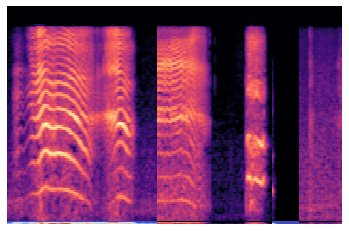

In [35]:
create_images(hungry_data,modeltype='poly',typeimg='mel_spectrogram',label_dir= 'hungry',num=0)
create_images(tired_data,modeltype='poly',typeimg='mel_spectrogram',label_dir= 'tired',num=1)
create_images(burping_data,modeltype='poly',typeimg='mel_spectrogram', label_dir='burping',num=2)
create_images(discomfort_data,modeltype='poly',typeimg='mel_spectrogram', label_dir='discomfort',num=3)
create_images(poop_data,modeltype='poly',typeimg='mel_spectrogram', label_dir='poop',num=4)